### VGG not work!!!!


12/08
12/09
12/10
VGG16/16 seems not works? train fail at step-2/epoch-1,
tensorflow-21.06-tf2-py3:tf25odocrpp2111 2nd steps faile out (tf2.5)
tensorflow-21.08-tf2-py3:latest 可以跑了(tf2.5) 差異在cuda版本  


12/10
12/11
Let test other SOTA models (ViT, BiT, ConvMixer...)
ViT:






### 1. ENV
#### <font color=#FF6600>[ENV] Turn off the error from twcc's AMP issue</font>

In [43]:
!export TF_ENABLE_AUTO_MIXED_PRECISION=0

#no work
!export TF_FORCE_GPU_ALLOW_GROWTH=1
# !export drop_remainder=False

# !export TF_ENABLE_AUTO_MIXED_PRECISION=1
# !export TF_ENABLE_AUTO_MIXED_PRECISION_GRAPH_REWRITE=1



In [44]:
# !sh install_env.sh
# !pip install -U --quiet vit-keras

#### <font color=#FF6600>[ENV] Moduls importing</font>

In [45]:
import os
# set log need before import tf
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["AUTOGRAPH_VERBOSITY"] = "0"

import cv2
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

# ViT (tf.hub version)
import tensorflow_hub as hub

# # ViT (vit-keras)
# from vit_keras import vit
# import tensorflow_addons as tfa


from tqdm import tqdm
from datetime import datetime
import seaborn as sns
import errno
import json


# albumentations
from functools import partial
import albumentations as A

# RandAugment, AutoAugment
from augment import RandAugment,AutoAugment


from pytictoc import TicToc

t = TicToc() #create instance of class

t.tic() #Start time

In [46]:
print(f'tf: {tf.__version__} \ncv2: {cv2.__version__} \nnp: {np.__version__} \npd: {pd.__version__} \nmatplotlib: {matplotlib.__version__}')
t.toc()

tf: 2.5.0 
cv2: 4.5.3 
np: 1.19.5 
pd: 1.3.2 
matplotlib: 3.4.3
Elapsed time is 0.007991 seconds.


#### <font color=#FF6600>[ENV] Parameters</font>


In [47]:
# Image size
BATCH_SIZE = 4 #2 # 8# 32 #64 #64:512*8 OOM, B7+bs8:RecvAsync is cancelled
img_height = 512 #600 #512 #120
img_width = 512 #600 #512 #120

patience_1 = 5
patience_2 = 10

# 自動調節tf.data管道
AUTOTUNE = tf.data.experimental.AUTOTUNE

# visible/logical device (able to be used)
print(tf.config.experimental.list_physical_devices('GPU'),'\n')
print(tf.config.experimental.list_logical_devices('GPU'),'\n')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num logical_gpus  :", len(tf.config.experimental.list_logical_devices('GPU')))

# tf MirroredStrategy seting
strategy = tf.distribute.MirroredStrategy()
REPLICAS = strategy.num_replicas_in_sync
print('\nNumber of REPLICAS: {}\n'.format(REPLICAS))


MULTI_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
print('BATCH_SIZE: {}, MULTI_BATCH_SIZE: {}'.format(BATCH_SIZE, MULTI_BATCH_SIZE))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')] 

[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU'), LogicalDevice(name='/device:GPU:2', device_type='GPU'), LogicalDevice(name='/device:GPU:3', device_type='GPU'), LogicalDevice(name='/device:GPU:4', device_type='GPU'), LogicalDevice(name='/device:GPU:5', device_type='GPU'), LogicalDevice(name='/device:GPU:6', device_type='GPU'), LogicalDevice(name='/device:GPU:7', device_type='GPU')] 

Num GPUs Available

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')



Number of REPLICAS: 8

BATCH_SIZE: 4, MULTI_BATCH_SIZE: 32


### 2. Dataset (DS)

#### <font color=orange>[DS] Create the training dataset W/ croped</font>
#### <font color=#00FF00>[DS] Create the training dataset W/ croped</font>

    label_num_to_disease_map.json    {
    "0": "Cassava Bacterial Blight (CBB)", 
    "1": "Cassava Brown Streak Disease (CBSD)", 
    "2": "Cassava Green Mottle (CGM)", 
    "3": "Cassava Mosaic Disease (CMD)", 
    "4": "Healthy"}

In [48]:
CLASSES = ['CBB', 
           'CBSD', 
           'CGM', 
           'CMD', 
           'Healthy']
LABELS = {"0": "CBB", 
          "1": "CBSD", 
          "2": "CGM", 
          "3": "CMD", 
          "4": "Healthy"}

data_dir = '/home/u3148947/.keras/datasets/leaf/'
# leaf_dir = 'leaf/leaf_labels/'
leaf_dir = '/home/u3148947/.keras/datasets/leaf/train_images/'

df_train = pd.read_csv(data_dir + '/train.csv')


In [49]:
# check lables
for i in range(5):
    print(i, CLASSES[i])
print([(i,l) for i,l in zip(LABELS.keys(), LABELS.values())])

for i,l in zip(LABELS.keys(), LABELS.values()):
    print(i,l)

0 CBB
1 CBSD
2 CGM
3 CMD
4 Healthy
[('0', 'CBB'), ('1', 'CBSD'), ('2', 'CGM'), ('3', 'CMD'), ('4', 'Healthy')]
0 CBB
1 CBSD
2 CGM
3 CMD
4 Healthy


In [50]:
len(df_train)

21397

In [51]:
df_train[:5]

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [52]:
# Shuffle and reset index
# fixed shuffle for compare later, random_state=42
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [53]:
df_train[:5]

,image_id,label
0,2615227158.jpg,4
1,1277648239.jpg,3
2,2305895487.jpg,3
3,336299725.jpg,2
4,1951270318.jpg,2


In [54]:
df_train.count()

image_id    21397
label       21397
dtype: int64

In [55]:
freq = df_train.groupby(['label']).count() 
print(freq)

       image_id
label          
0          1087
1          2189
2          2386
3         13158
4          2577


3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64


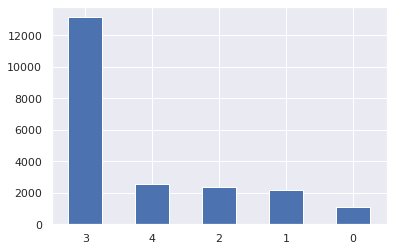

In [56]:
# get no key freq
freq = df_train['label'].value_counts() 
ax = freq.plot.bar(x='image_id', y='label', rot=0) #no key so x y no matter.
print(freq)


#### <font color=#00FF00>[DS] Create tf.dataset (DS)</font>

In [57]:
# from dataframe
list_ds = tf.data.Dataset.from_tensor_slices((df_train['image_id'], df_train['label']))

In [58]:
# create a Python iterator

it_list_ds = iter(list_ds) # Make sure iter ds only once.

In [59]:
# using iter and consuming its elements using next: every print different image name.

for i in range(4):
    image_id, label = next(it_list_ds)
    print(image_id.numpy(), label.numpy())

b'2615227158.jpg' 4
b'1277648239.jpg' 3
b'2305895487.jpg' 3
b'336299725.jpg' 2


In [60]:
#
# map list to ds.
#
def process_path_label(image_id, label):
    file_path = leaf_dir + image_id
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8) # for resize the training image for faster checing!
    return img, label

In [61]:
# Leaf train ds
train_ds_map = list_ds.map(process_path_label, num_parallel_calls=AUTOTUNE)

#### <font color=#00FF00>[DS] Split TVT</font>
train/val/test with ratio 7. 1.5 1.5

In [62]:
# split TVT train/val/test 7 1.5 1.5


val_size = int(tf.data.experimental.cardinality(train_ds_map).numpy() * 0.15)
# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.1)#no help

print("val size:", val_size)

train_ds_map_s = train_ds_map.skip(val_size+val_size)
temp_s = train_ds_map.take(val_size+val_size)

valid_ds_map_s = temp_s.take(val_size)
test_ds_map_s = temp_s.skip(val_size)

print("total size:", len(train_ds_map))
print("\ntrain", tf.data.experimental.cardinality(train_ds_map_s).numpy())
print("valid", tf.data.experimental.cardinality(valid_ds_map_s).numpy())
print("test", tf.data.experimental.cardinality(test_ds_map_s).numpy())


val size: 3209
total size: 21397

train 14979
valid 3209
test 3209


In [63]:
# # create iterator once
# iter_map = iter(train_ds_map_s)

In [64]:
# %%time
# # get new image every next time
# image, label = next(iter_map)

# plt.figure(figsize=(10, 10))
# plt.imshow(image)
# plt.title(f'Image dtype: {image.dtype} and the range: {image.numpy().min()} to {image.numpy().max()}, shape:{image.shape}')

# print(f'Lable: {label}')

# """
# png
# Lable: 4
# CPU times: user 18.8 s, sys: 934 ms, total: 19.7 s
# Wall time: 36.6 s

# jpg
# Lable: 4
# CPU times: user 13.4 s, sys: 370 ms, total: 13.8 s
# Wall time: 3.57 s
# """

#### <font color=#00FF00>[DS] Augmentation and performance cache pipeline</font>

In [65]:
## AA, auto aug test

# image = tf.io.read_file(str(CMD[1]))
# image = tf.image.decode_jpeg(image, channels=3)


def AA(image, label):
    Auto_Aug = AutoAugment()
#     auto_img = Auto_Aug.distort(image)
    return Auto_Aug.distort(image), label


def RA(image, label):
    Rand_Aug = RandAugment()
#     auto_img = Auto_Aug.distort(image)
    return Rand_Aug.distort(image), label


## DS performance cache

def configure_for_performance_cache(ds, cache=True, augment=False):  
    """#TODO: need to check the parse logic of ds.cache.
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
#         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
        ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
#         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE, reshuffle_each_iteration=True) #buffer_size=MULTI_BATCH_SIZE*2 10sec. # (buffer_size=MULTI_BATCH_SIZE*5) ~10sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
    """Note: While large buffer_sizes shuffle more thoroughly, they can take a lot of memory, and 
        significant time to fill. Consider using Dataset.interleave across files if this becomes a problem."""
    
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds

In [66]:
augment=True#False #aug, AA, RA, ADA

train_ds_pre = configure_for_performance_cache(train_ds_map_s, cache=True, augment=augment)
valid_ds_pre = configure_for_performance_cache(valid_ds_map_s)
test_ds_pre = configure_for_performance_cache(test_ds_map_s)

Check cache in memory:Y True
Check augment :Y True
Check ds cache[True] and augment[True]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]


In [67]:
# %%time

# print('AUTOTUNE=', AUTOTUNE)

# import math
# col_row = math.sqrt(int(BATCH_SIZE))

# plt.figure(figsize=(20, 20))
# for images, labels in train_ds_pre.take(1):
#     print('batch * multi:', len(labels))
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(f'labels:{labels[i]}, {CLASSES[labels[i]]}')
#         plt.axis("off")
        
# #why take so long
# """
# tf.io.decode_png
# AUTOTUNE= -1
# batch * multi: 64
# CPU times: user 9min 52s, sys: 23.5 s, total: 10min 15s
# Wall time: 5min 10s

# tf.io.decode_jpeg
# AUTOTUNE= -1
# batch * multi: 64
# CPU times: user 9min 40s, sys: 22.6 s, total: 10min 2s
# Wall time: 3min 39s

# """

In [68]:
# %%time
# print('AUTOTUNE=', AUTOTUNE)
# # too long

# #J 新版：tf2.3

# image_batch, label_batch = next(iter(train_ds_pre))
# plt.figure(figsize=(10, 10))
# plt.imshow(image_batch[1].numpy().astype("uint8"))
# # image_batch[1]

# print(f'Image dtype: {image_batch[1].dtype} and the range: {image_batch[1].numpy().min()} to {image_batch[1].numpy().max()}')

# """tf.cast(uint8) will hard fit source to 0-255"""

# """AUTOTUNE= -1
# Image dtype: <dtype: 'uint8'> and the range: 0 to 255
# CPU times: user 8min 56s, sys: 5.43 s, total: 9min 1s
# Wall time: 3min 28s

# AUTOTUNE= -1
# Image dtype: <dtype: 'uint8'> and the range: 0 to 255
# CPU times: user 8min 59s, sys: 5.81 s, total: 9min 5s
# Wall time: 3min 29s
# """

In [69]:
t.tic()

In [70]:
# # create it_ds once
# it_train_ds_pre_toe_s = iter(train_ds_pre)

In [71]:
# %%time

# image_batch, label_batch = next(it_train_ds_pre_toe_s)

# fig = plt.figure(figsize=(8, 8))
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")
   
#     # 2021-11-05
#     # Check jpg, png agter ds is [0-255]
#     print(' [min,max]:', image_batch[i].numpy().min() , image_batch[i].numpy().max()) 
    
#     print(f'Check lables: {label_batch[i]}')

# """CPU times: user 8min 54s, sys: 4.8 s, total: 8min 58s
# Wall time: 3min 27s

# CPU times: user 9min 2s, sys: 5.46 s, total: 9min 7s
# Wall time: 3min 30s

# ds.shuffle buffer_sizes  = MULTI_BATCH_SIZE
# CPU times: user 22 s, sys: 552 ms, total: 22.6 s
# Wall time: 7.75 s
# """

In [72]:
t.toc()

Elapsed time is 0.027763 seconds.


In [73]:
# %%time
# t.tic()
# num_bs=0
# for bs in tqdm(train_ds_pre):
# #     print(type(bs))
# #     print(".",end="")
# #     print(len(bs))
#     print([len(a) for a in bs])
#     num_bs += 1
# print("num_bs=", num_bs)
# t.toc()


"""跑完整個ds需要3min33s
100%|██████████| 235/235 [03:33<00:00,  1.10it/s]
num_bs= 235
Elapsed time is 213.461381 seconds.
CPU times: user 9min 1s, sys: 8.04 s, total: 9min 9s
Wall time: 3min 33s
"""

'跑完整個ds需要3min33s\n100%|██████████| 235/235 [03:33<00:00,  1.10it/s]\nnum_bs= 235\nElapsed time is 213.461381 seconds.\nCPU times: user 9min 1s, sys: 8.04 s, total: 9min 9s\nWall time: 3min 33s\n'

In [74]:
### 4. Models

### 4. Models

#### <font color="yellow"> [Models] </font>

In [85]:



"""
aps: module 'tensorflow.keras.applications' from '/usr/local/lib/python3.8/dist-packages/tensorflow/keras/applications/__init__.py
vim /usr/local/lib/python3.8/dist-packages/tensorflow/keras/applications/__init__.py

可以實現由動態字串變數載入特定的基本模型<但是太多處理>還不如直接表列每項寫出來的清楚簡單!!!!

Model_List = ["Xception", "ResNet50", "ResNet101", "ResNet152", "InceptionV3", "MobileNet", "MobileNetV2", 
"DenseNet121","DenseNet169","DenseNet201",
"NASNetMobile","NASNetLarge", 
"EfficientNetB0",
"EfficientNetB1", #13
"EfficientNetB3",
"EfficientNetB5", #15
"EfficientNetB7",
]
"""
import importlib 



    
def build_efn_model(model_name, outputnum, top_dropout_rate, drop_connect_rate):
    
    # move to Top 
    inputs = tf.keras.Input(shape=(img_height, img_width, 3)) #shape=(120, 120, 3), img_height, img_width shape=(img_height, img_width, 3)
    
    # EfficientNetB@# #
#     # OK efn
#     if model_name.startswith('EfficientNetB'):# == "EfficientNetB0":
#         root_m_name = 'efficientnet'
#         fullnameofmodel = "tensorflow.keras.applications." + root_m_name #model_name #model_name.lower()
#         model = importlib.import_module(fullnameofmodel)
#         BaseCnn = getattr(model,model_name)       
#         base_model = BaseCnn(include_top=False, weights="imagenet", input_shape=(120,120,3),drop_connect_rate=drop_connect_rate) #{'imagenet', None}
    # shorter version of OK efn
    if model_name.startswith('EfficientNetB'):
        """For EfficientNet, input preprocessing is included as part of the model (as a Rescaling layer)."""
        BaseCnn = getattr(importlib.import_module("tensorflow.keras.applications.efficientnet"), model_name)       
        base_model = BaseCnn(include_top=False, weights="imagenet", drop_connect_rate=drop_connect_rate) #{'imagenet', None}
        # NO extra rescale need, efn already include the scaling inside the model
        rescaling_input = inputs
        
    # Xception #
    """When run in "tf" mode it actuallly expect the input to be uint8 between 0 and 255 and scales it to the range from -1.0 to 1.0. 
    Check the docstring and the source code.""" #NOT TRUE
    """ For Xception, call tf.keras.applications.xception.preprocess_input on your inputs before passing them to the model. 
    xception.preprocess_input will scale input pixels between -1 and 1."""
    if model_name.startswith('Xception'):
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.xception"), model_name)     
        base_model = BaseCnn(include_top=False, weights="imagenet") #{'imagenet', None}
        
        rescaling_input = tf.keras.applications.xception.preprocess_input(inputs)

    # ResNet50 ResNet101 ResNet152 #
    if model_name.startswith('ResNet'):
        """For ResNet, call tf.keras.applications.resnet.preprocess_input on your inputs before passing them to the model. 
        resnet.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel with 
        respect to the ImageNet dataset, without scaling."""
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.resnet"), model_name)     
        base_model = BaseCnn(include_top=False, weights="imagenet") #{'imagenet', None}    
        
        rescaling_input = tf.keras.applications.resnet.preprocess_input(inputs)
        
    # InceptionV3 #
    if model_name.startswith('InceptionV3'):
        """For InceptionV3, call tf.keras.applications.inception_v3.preprocess_input on your inputs before passing them to the model. 
        inception_v3.preprocess_input will scale input pixels between -1 and 1."""
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.inception_v3"), model_name)     
        base_model = BaseCnn(include_top=False, weights="imagenet") #{'imagenet', None}    
        
        rescaling_input = tf.keras.applications.inception_v3.preprocess_input(inputs)        

    # MobileNet #
    if model_name.endswith('MobileNet'):
        """ For MobileNet, call tf.keras.applications.mobilenet.preprocess_input on your inputs before passing them to the model. 
        mobilenet.preprocess_input will scale input pixels between -1 and 1."""
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.mobilenet"), model_name)     
        base_model = BaseCnn(include_top=False, weights="imagenet") #{'imagenet', None}    
        
        rescaling_input = tf.keras.applications.mobilenet.preprocess_input(inputs)             
        
    # MobileNetV2 #
    if model_name.startswith('MobileNetV2'):
        """ For MobileNetV2, call tf.keras.applications.mobilenet_v2.preprocess_input on your inputs before passing them to the model. 
        mobilenet_v2.preprocess_input will scale input pixels between -1 and 1."""
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.mobilenet_v2"), model_name)     
        base_model = BaseCnn(include_top=False, weights="imagenet") #{'imagenet', None}    
        
        rescaling_input = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)            
        
    # DenseNet121 DenseNet169 DenseNet201 #
    if model_name.startswith('DenseNet'):
        """ For DenseNet, call tf.keras.applications.densenet.preprocess_input on your inputs before passing them to the model."""
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.densenet"), model_name)     
        base_model = BaseCnn(include_top=False, weights="imagenet") #{'imagenet', None}    
        
        rescaling_input = tf.keras.applications.densenet.preprocess_input(inputs)            
        
    # NASNet: NASNetMobile #
    if model_name.startswith('NASNetMobile'):
        """For NASNet, call tf.keras.applications.nasnet.preprocess_input on your inputs before passing them to the model."""
        """Optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3)
        for NASNetMobile It should have exactly 3 inputs channels, and width and height should be no smaller than 32. E.g. (224, 224, 3) 
        would be one valid value. For loading imagenet weights, input_shape should be (224, 224, 3)"""
        
        """otherwise the input shape has to be (331, 331, 3) for NASNetLarge. It should have exactly 3 inputs channels, and width and height should 
        be no smaller than 32. E.g. (224, 224, 3) would be one valid value.  For loading imagenet weights, input_shape should be (331, 331, 3)"""
        """ NASNetMobile imagenet with 224: ted 10.x/5.x 
            NASNetMobile None with 120: ted 12.x/4.x,  seem no different at fine tune phase. """
        
        """pre-set use inputs = tf.keras.Input([None, None, 3]) to fake run build mode to get the model weight.  Then, run
        on normal build with specific input size without imagenet-weight, and reload the weight by hand.
        Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/nasnet/nasnet_mobile_no_top.h5
        Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/nasnet/NASNet-large-no-top.h5
        https://github.com/keras-team/keras-applications/issues/78
        """
        """Very large model, NASNetLarge take 8xM parameters, take 800~300 sec for one epoch.
        Epoch 00015: val_accuracy did not improve from 0.87036
        [306.6111526489258] of epoch 15
        CPU times: user 7h 30min 14s, sys: 32min 2s, total: 8h 2min 16s
        Wall time: 1h 26min 32s
        
        NASNetMobile: but loss: nan after epcoh 1, need reduce the lr!!!!!!!!!!!!!!!!!!!!!!!!!!!!!![12/14]Fixed by seprating mobile/large to two functions.
        Epoch 00011: val_accuracy did not improve from 0.64444
        [124.91568398475647] of epoch 11
        CPU times: user 3h 19min 49s, sys: 3min 41s, total: 3h 23min 31s
        Wall time: 29min 27s
        """
        # Pre download the model first for it weight later we need to reload it.
#         inputs = tf.keras.Input([None, None, 3])

        rescaling_input = tf.keras.applications.nasnet.preprocess_input(inputs)     

        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.nasnet"), model_name)     
#         base_model = BaseCnn(include_top=False, weights="imagenet") #{'imagenet', None}    
#         base_model = BaseCnn(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3)) #{'imagenet', None} for set input to 120x120    
#         base_model = BaseCnn(include_top=False, weights='imagenet') #{'imagenet', None} for set input to 120x120    

        # load weight by hand.
        base_model = BaseCnn(include_top=False, weights=None, input_shape=(img_height, img_width, 3))
        base_model.load_weights('/home/u3148947/.keras/models/nasnet_mobile_no_top.h5')
    
#         inputs = tf.keras.layers.Resizing(224, 224) # tf >= 2.6.0, but currnet TWCC newest 21.08 is tf=2.5.0
#         i = tf.compat.v1.keras.layers.experimental.preprocessing.Resizing(224, 224)(inputs)
#         x = tf.cast(i, tf.float32)


    # NASNet: NASNetLarge #
    if model_name.startswith('NASNetLarge'):
        rescaling_input = tf.keras.applications.nasnet.preprocess_input(inputs)     

        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.nasnet"), model_name)    
        
        # load weight by hand.
        base_model = BaseCnn(include_top=False, weights=None, input_shape=(img_height, img_width, 3))
        base_model.load_weights('/home/u3148947/.keras/models/nasnet_large_no_top.h5')        
        
        
        
    # VGG16 #
    """VGG16 not train even with None or Imagenet. pooling= is not the factor"""
    if model_name.startswith('VGG16'):
        """For VGG16, call tf.keras.applications.vgg16.preprocess_input on your inputs before passing them to the model. 
        vgg16.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel 
        with respect to the ImageNet dataset, without scaling."""
#         BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.vgg16"), model_name)     
#         base_model = BaseCnn(include_top=False, weights='imagenet') #{'imagenet', None}
        
#         base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
        
#         rescaling_input = tf.keras.applications.vgg16.preprocess_input(inputs)  

#         base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=rescaling_input)

#        base_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))


        base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=inputs)



    # VGG19 #
    if model_name.startswith('VGG19'):
        """For VGG19, call tf.keras.applications.vgg19.preprocess_input on your inputs before passing them to the model. 
        vgg16.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel 
        with respect to the ImageNet dataset, without scaling."""
        
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.vgg19"), model_name)     
        base_model = BaseCnn(include_top=False, weights="imagenet") #{'imagenet', None}    
        
        rescaling_input = tf.keras.applications.vgg16.preprocess_input(inputs)  
        

    # ViT # tf.hub version [Waiting for twcc update CCS image for version 21.11]
    if model_name.startswith('ViT'):
        """Inputs to the model must:
            1.be four dimensional Tensors of the shape (batch_size, height, width, num_channels). Note that the model expects images with channels_last property. num_channels must be 3.
            2.be resized to 224x224 resolution.
            3.have pixel values in the range [-1, 1].
        """
        """ValueError: Unknown SavedObject type: None
        but work in wth tf2.6.0, tf2.7.0

        """
        if model_name.startswith('ViT_b8'):
            handle="https://tfhub.dev/sayakpaul/vit_b8_fe/1"
        if model_name.startswith('ViT_s16'):
            handle="https://tfhub.dev/sayakpaul/vit_s16_fe/1"
        num_classes=5
        
        # ViT model as a layer
        hub_layer = hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_b8_fe/1", trainable=True)
        model = tf.keras.Sequential([
                                        inputs,
                                        hub_layer,
                                        keras.layers.Dense(num_classes, activation="softmax"),
                                        ])
 
 
    
#     # ViT # ViT-keras, but seems need more epoch to train.
#     if model_name.startswith('ViT'):
#         """For ViT (vit-keras)
#         There are models pre-trained on imagenet21k for the following architectures: ViT-B/16, ViT-B/32, ViT-L/16, ViT-L/32 and ViT-H/14. 
#         There are also the same models pre-trained on imagenet21k and fine-tuned on imagenet2012.
        
#         pip install -U --quiet vit-keras # for imagenet21k pre-trained weight.
#         pip install -U tensorflow-addons # for scratch
#         """
#         """base_model = vit.vit_b32
#         Downloading data from https://github.com/faustomorales/vit-keras/releases/download/dl/ViT-B_32_imagenet21k+imagenet2012.npz
        
#         base_model = vit.vit_b16
#         Downloading data from https://github.com/faustomorales/vit-keras/releases/download/dl/ViT-B_16_imagenet21k+imagenet2012.npz
#         """
#         """
#         ValueError: Input 0 of layer global_average_pooling2d is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 768)
#         seems need use Flatten() to capture laster feature output.
#         """
#         """AssertionError: image_size must be a multiple of patch_size
#         600 / 16 = 37.5
#         512 / 16 = 32, only works
#         """
#         from vit_keras import vit
#         #import tensorflow_addons as tfa
        
#         #vit_b16 vit_b32  vit_L16 vit_L32  
#         base_model = vit.vit_b16(
#             image_size = img_width,
#             activation = 'softmax',
#             pretrained = True, #True,
#             include_top = True,
#             pretrained_top = False,
#             classes = 5)
        
#         #rescaling_input = inputs
        
        
        
#     # template #
#     if model_name.startswith(''):
#         """For."""
#         BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications."), model_name)     
#         base_model = BaseCnn(include_top=False, weights="imagenet", input_shape=(120,120,3)) #{'imagenet', None}    
        
#         rescaling_input = tf.keras.applications.inception_v3.preprocess_input(inputs)  


#     # template #
#     if model_name.startswith(''):
#         """For."""
#         BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications."), model_name)     
#         base_model = BaseCnn(include_top=False, weights="imagenet", input_shape=(120,120,3)) #{'imagenet', None}    
        
#         rescaling_input = tf.keras.applications.inception_v3.preprocess_input(inputs)  


        

    
# # move to Top 
#     # How to add training=False in base_model create
#     #inputs = tf.keras.Input(shape=(120, 120, 3))
#     #rescal = rescaling_input()(inputs)
#     #b_m_output = base_model(inputs, training=False)
    
#     if model_name.startswith('ViT'):
# #         out = tf.keras.layers.Flatten()(base_model.output)
# #         out = tf.keras.layers.BatchNormalization()(out)
# #         out = tf.keras.layers.Dense(11, activation = tfa.activations.gelu)(out)
# #         out = tf.keras.layers.BatchNormalization()(out)
# #         outputs = tf.keras.layers.Dense(5, 'softmax')(out)
# #         model = tf.keras.Model(base_model.input, outputs, name=model_name)

#         """#vit_b16 vit_b32  vit_L16 vit_L32, just model.compile like tf.keras?!
#         """
#         base_model = vit.vit_b16(
#             image_size = img_width,
#             activation = 'sigmoid',
#             pretrained = True, #True,
#             include_top = True,
#             pretrained_top = False,
#             classes = 5)
#         model = base_model
        
#     else:
        
    
    # ViT # tf.hub version [Waiting for twcc update CCS image for version 21.11]
    if model_name.startswith('ViT'):
        """ViT was loaded above already."""
        pass

    else:
        # Freeze the pretrained weights
        base_model.trainable = False
        print("base_model.trainable : ", base_model.trainable)
        b_m_output = base_model(rescaling_input, training=False)

        # Rebuild top       
        gap2d = tf.keras.layers.GlobalAveragePooling2D()(b_m_output) #(base_model.output)
        #BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
        dropout = tf.keras.layers.Dropout(top_dropout_rate)(gap2d)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
        #outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help
        outputs = tf.keras.layers.Dense(5, activation="softmax")(dropout)#todo: activation="softmax", default is "linear" activation: a(x) = x


        # Compile new model
        model = tf.keras.Model(inputs, outputs, name=model_name)

    
    
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
                 metrics=['accuracy'])
    
    return model, base_model


# Pick a model #
Model_List = ["Xception", "ResNet50", "ResNet101", "ResNet152", "InceptionV3", "MobileNet", "MobileNetV2", # 0-6 
"DenseNet121","DenseNet169","DenseNet201", # 7 8 9
"NASNetMobile","NASNetLarge", # 10 11 (hard code of size!224 331!)
"EfficientNetB0", #12
"EfficientNetB1", #13
"EfficientNetB3",
"EfficientNetB5", #15
"EfficientNetB7", #16
'VGG16', # 17 #train fail
'VGG19', # 18
'ViT_b8', #19 Vision Transformer
'BiT', #20 BigTransfer
'ConvMixer', #21
]

model_name = Model_List[19]
# print(Model_List[1:3])
print(model_name)


ViT_b8


#### <font color="yellow"> [Models] Train misc. </font>

In [86]:
monitor = 'val_accuracy' #'val_loss' 'val_accuracy' if use ed_loss it still the loss here.

def mk_log_dir(log_dir_name):
    try:
        os.makedirs(log_dir_name)
    except OSError as e:
        print("This log dir exist.")
        if e.errno != errno.EEXIST:
            raise ValueError("we got problem.")

def get_best_model_name(th):
    return './' + log_dir_name + '/' + th + '_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_best_' + monitor + '.h5'

# th = 'toe'
# th = 'heel'

th = "stage1"


In [87]:
# use once at the time
# log_dir_name = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir_name = "TrainSaveDir"

mk_log_dir(log_dir_name)

best_model_name = get_best_model_name(th)

best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
                             save_best_only = True, 
                             save_weights_only = False,
                             monitor = monitor, 
                             mode = 'auto', verbose = 1)
print('best_model_name:', best_model_name)

logdir = log_dir_name + "/logs/toe/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

This log dir exist.
best_model_name: ./TrainSaveDir/stage1_ViT_b8_bs4_w512_best_val_accuracy.h5


#### <font color="yellow"> [Models] Learning Rate Scheduler </font>

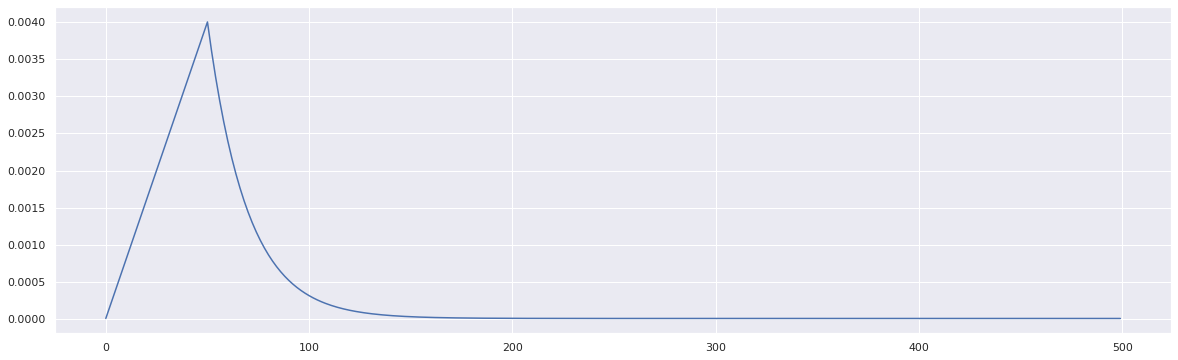

In [88]:
"""dump lr
"""
ep_num_transf = 500



def lrdump(epoch):
    
    #step_size = 100
    lr_max = 0.004
    lr_min = 0.00001
    lr_start = 0.00001

    lr_init_ep = 0
    lr_ramp_ep = 50
    lr_sus_ep  = 0 #10
    lr_decay   = 0.95

    
    # warm up
    if epoch < lr_init_ep:
        lr = (lr_max - lr_min) / lr_ramp_ep * epoch + lr_min    
        
    elif lr_init_ep -1 < epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

rng = [i for i in range(ep_num_transf)]
y = [lrdump(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [89]:
""" [LR] Stepwise warmup cosine decay restart.
todo
"""


# def lr_step_WCDR(step):



' [LR] Stepwise warmup cosine decay restart.\ntodo\n'

In [90]:
print('{} ~ {}'.format(min(y), max(y)))

1e-05 ~ 0.004


In [91]:
for e, lr in zip(rng,y):
    print('{}\t {}\n'.format(e, lr))

0	 1e-05

1	 8.980000000000001e-05

2	 0.00016960000000000003

3	 0.00024940000000000004

4	 0.0003292000000000001

5	 0.0004090000000000001

6	 0.0004888000000000001

7	 0.0005686000000000002

8	 0.0006484000000000001

9	 0.0007282000000000001

10	 0.0008080000000000001

11	 0.0008878000000000002

12	 0.0009676000000000002

13	 0.0010474000000000002

14	 0.0011272000000000003

15	 0.0012070000000000002

16	 0.0012868000000000003

17	 0.0013666000000000004

18	 0.0014464000000000002

19	 0.0015262000000000003

20	 0.0016060000000000002

21	 0.0016858000000000003

22	 0.0017656000000000004

23	 0.0018454000000000003

24	 0.0019252000000000004

25	 0.0020050000000000003

26	 0.0020848000000000004

27	 0.0021646000000000005

28	 0.0022444000000000006

29	 0.0023242000000000007

30	 0.0024040000000000003

31	 0.0024838000000000004

32	 0.0025636000000000005

33	 0.0026434000000000006

34	 0.0027232000000000007

35	 0.0028030000000000004

36	 0.0028828000000000005

37	 0.0029626000000000006

#### <font color="yellow"> [Models] Callback </font>

In [92]:
# 2021-11-25 #
#TODO: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback 改寫為callbacks.on_epoch_begin(epoch) 並加入datetime方便在訓練時觀察時間
class PrintLR(tf.keras.callbacks.Callback):
#     def on_epoch_begin(self, epoch, logs=None):
#         self.epoch=epoch
#         print(f"第 {epoch} 執行週期開始...")
#     def on_epoch_end(self, epoch, logs=None):
#         print('\nLearning rate for epoch {} is {}'.format(epoch + 1, model.optimizer.lr.numpy()))


#     def on_epoch_begin(self, epoch, logs=None):
#         print(f'[{datetime.now()}] Learning rate for epoch {epoch + 1} is {model.optimizer.lr.numpy()}')
        
    # time of epoch
    def on_train_begin(self,  epoch, logs=None):
        self.times = []
    def on_epoch_begin(self,  epoch, logs=None):
        self.epoch_time_start = time.time()
        print(f'[{datetime.now()}] Learning rate for epoch {epoch + 1} is {model_toe.optimizer.lr.numpy()}')
#         s_time = time.time()
#         print("start")
    def on_epoch_end(self,  epoch, logs=None):
        wall_time = time.time() - self.epoch_time_start
        self.times.append(wall_time)
        #print(f'[{self.times}] of epoch {epoch + 1}')
        print(f'[{wall_time}] of epoch {epoch + 1}')
        
callback_lr_time = PrintLR() #return a object of callback, not use the Classs PrintLR.

In [93]:
callbacks = [
#     tensorboard_callback,
    best_model_save,
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience_1), #patience=step_size or ep_num
#     lr_reduceonplateau,
    tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
    callback_lr_time
#     tensorboard_callback,
]

#### <font color="yellow"> [Models] Build models </font>

In [94]:
top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
outputnum = 2

with strategy.scope():
    # Model building/compiling need to be within `strategy.scope()`.
    model_toe, base_model = build_efn_model(model_name, outputnum, top_dropout_rate, drop_connect_rate) # for efnet, Xincept


ValueError: Unknown SavedObject type: None

In [ ]:
len(model_toe.layers)

In [ ]:
tt = 0
nt = 0
for layer in model_toe.layers:
    if layer.trainable:
        tt +=1
        print(f'{layer.name}')
    else:
        nt +=1
print(f'tt: {tt}, nt:{nt}')

def count_model_trainOrNot_layers(model, printlayers=False):
    tt = 0
    nt = 0
    for layer in model.layers:
        if layer.trainable:
            tt +=1
            if printlayers:
                print(f'{layer.name}')
        else:
            nt +=1
    print(f'tt: {tt}, nt:{nt}, total layers:{tt+nt}')

In [ ]:
count_model_trainOrNot_layers(model_toe)

In [ ]:
base_model.summary()

In [ ]:
model_toe.summary()

#### <font color="yellow"> [Models] Train top layers (transfer learning)</font>

In [ ]:
# %%time

# # fit the model on all data
# history_toe = model_toe.fit(train_ds_pre, 
#                       verbose=1, 
#                       epochs=5, #ep_num_transf, 
#                       validation_data=valid_ds_pre, 
#                       callbacks=callbacks)#, validation_split=0.1)

In [49]:
[2021-12-10]
看來網誌版本的也不能訓練，應該是跟tf ccs版本有關。

tensorflow-21.06-tf2-py3:tf25odocrpp2111 2nd steps faile out
    

tensorflow-21.08-tf2-py3:latest 可以跑了    

SyntaxError: invalid character in identifier (4013923208.py, line 2)

In [ ]:
# EFntB7 
# inputs = 600*600, 8 gpu, bs4x8

# TL seems not work!


EFntB7 
inputs = 512*512, 8 gpu, bs32x8

Epoch 00012: val_accuracy improved from 0.73917 to 0.74478, saving model to ./TrainSaveDir/stage1_EfficientNetB7_bs32_w512_best_val_accuracy.h5
[40.45903658866882] of epoch 12
Epoch 13/500
[2021-12-07 13:03:08.241426] Learning rate for epoch 13 is 0.0009675999754108489
59/59 [==============================] - 39s 618ms/step - loss: 0.7936 - accuracy: 0.7024 - val_loss: 0.6922 - val_accuracy: 0.7445

Epoch 00013: val_accuracy did not improve from 0.74478
[38.982457876205444] of epoch 13
CPU times: user 1h 30min 59s, sys: 9min 19s, total: 1h 40min 19s
Wall time: 13min 11s

MBnetV2
DS, inputs = 512*512, 8 gpu, bs32x8

MBnetV2
DS, inputs = 512*512, 8 gpu, bs64x8


Epoch 00032: val_accuracy did not improve from 0.72608
[34.99274802207947] of epoch 32
CPU times: user 3h 1min 32s, sys: 8min 26s, total: 3h 9min 59s
Wall time: 21min

MBnetV2
DS, inputs = 120*120

Epoch 00016: val_accuracy did not improve from 0.68027
[11.85263991355896] of epoch 16
Epoch 17/500
235/235 [==============================] - 12s 44ms/step - loss: 1.1775 - accuracy: 0.6076 - val_loss: 0.9085 - val_accuracy: 0.6768


### Fine tune

In [50]:
def unfreeze_model(model, base_model):
#     # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
#     for layer in model.layers[-20:]:
#         if not isinstance(layer, layers.BatchNormalization):
#             layer.trainable = True

#     model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.





#     fine_tune_at = 20 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model_toe.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             layer.trainable = True


#
#'block7a_expand_conv'20 'block6c_expand_conv'50 'block6a_expand_conv'79 'block5b_expand_conv'109 'block4a_expand_conv' 166 
#

    # Set All layers trainable first
    #model.trainable = True #範例似乎是指 base_model.trainable = True 而不是新建model！！！！！！(2021-11-08)
    base_model.trainable = True
    
    
    
    # Then, set layers NOT trainable below specific layer.
#     set_trainable = False
#     for layer in model.layers:
#         if layer.name == 'block5b_expand_conv': 
#             set_trainable = True
#         if set_trainable:
#             layer.trainable = True
#         else:
#             layer.trainable = False

#     model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
#                     loss=ed_metric_2d_mean)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
                 metrics=['accuracy'])


In [51]:
# unfreeze for finetune the toe model  
unfreeze_model(model_toe,base_model)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [52]:
count_model_trainOrNot_layers(model_toe)

tt: 20, nt:0, total layers:20


In [53]:
th = 'stage2'
best_model_name_s2 = get_best_model_name(th)

best_model_save_s2 = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name_s2, 
                             save_best_only = True, 
                             save_weights_only = False,
                             monitor = monitor, 
                             mode = 'auto', verbose = 1)
print('best_model_name_s2:', best_model_name_s2)

best_model_name_s2: ./TrainSaveDir/stage2_ViT_bs4_w512_best_val_accuracy.h5


In [54]:
lr_reduceonplateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor=monitor, factor=0.1, patience=5, verbose=1, 
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-12)

In [55]:
callbacks_s2 = [
#     tensorboard_callback,
    best_model_save_s2,
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience_2), #patience=step_size or ep_num
#     lr_reduceonplateau,
    tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
    callback_lr_time
#     tensorboard_callback,
]

In [56]:
%%time

# fit the model on all data
history_toe_finetune = model_toe.fit(train_ds_pre, 
                      verbose=1, 
                      epochs= 100,#ep_num_transf, 
                      validation_data=valid_ds_pre, 
                      callbacks=callbacks_s2)#, validation_split=0.1)

Epoch 1/100
[2021-12-11 22:18:06.130088] Learning rate for epoch 1 is 9.999999747378752e-06
INFO:tensorflow:batch_all_reduce: 200 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 200 all-reduces with algorithm = nccl, num_packs = 1
469/469 [==============================] - 349s 445ms/step - loss: 1.1247 - accuracy: 0.6129 - val_loss: 1.0050 - val_accuracy: 0.6447

Epoch 00001: val_accuracy improved from -inf to 0.64475, saving model to ./TrainSaveDir/stage2_ViT_bs4_w512_best_val_accuracy.h5
[349.88900542259216] of epoch 1
Epoch 2/100
[2021-12-11 22:23:58.026102] Learning rate for epoch 2 is 8.97999998414889e-05
469/469 [==============================] - 172s 357ms/step - loss:

KeyboardInterrupt: 

In [ ]:
for different DS: 800*600 ->> 512resize/600resize/512crop/600crop

EFntB7 
inputs = 600*600, 8 gpu, bs4x8

Epoch 00014: val_accuracy did not improve from 0.88252
[205.34342765808105] of epoch 14
CPU times: user 5h 35min 30s, sys: 20min 23s, total: 5h 55min 53s
Wall time: 56min 51s




In [ ]:
ResNet152 inputs = 512*512, 8 gpu, bs4x8

Epoch 00011: val_accuracy did not improve from 0.83640
[134.74419260025024] of epoch 11
CPU times: user 2h 26min 57s, sys: 4min 11s, total: 2h 31min 9s
Wall time: 29min 14s

In [ ]:
Xception inputs = 512*512, 8 gpu, bs4x8

somehow TL not work??? cause FT train from inf!

Epoch 00005: val_accuracy did not improve from 0.83017
[79.85516905784607] of epoch 5
CPU times: user 48min 24s, sys: 2min 27s, total: 50min 51s
Wall time: 8min 13s
    
Epoch 00018: val_accuracy did not improve from 0.86600
[72.12753582000732] of epoch 18
CPU times: user 2h 37min 51s, sys: 4min 40s, total: 2h 42min 32s
Wall time: 23min 47s    

DenseNet201  inputs = 512*512, 8 gpu, bs4x8

after 4 mins, it ran. (without TL [stage1])

Epoch 00005: val_accuracy did not improve from 0.81739
[113.5602593421936] of epoch 5
Epoch 6/500
[2021-12-07 17:04:56.111606] Learning rate for epoch 6 is 0.0004090000002179295
469/469 [==============================] - 113s 237ms/step - loss: 0.6786 - accuracy: 0.7655 - val_loss: 0.6962 - val_accuracy: 0.7918

Epoch 00006: val_accuracy did not improve from 0.81739
[113.0628821849823] of epoch 6
CPU times: user 1h 34min 3s, sys: 2min 42s, total: 1h 36min 46s
Wall time: 17min 21s

EFntB7 inputs = 512*512, 8 gpu, bs4x8

after 5 mins, it ran. (without TL [stage1])

[592.2609107494354] of epoch 1
[210.42193007469177] of epoch 3
Epoch 00004: val_accuracy did not improve from 0.88221
[181.73404240608215] of epoch 4

Epoch 5/500
[2021-12-07 15:54:04.367304] Learning rate for epoch 5 is 0.00032920000376179814
469/469 [==============================] - 180s 381ms/step - loss: 0.3675 - accuracy: 0.8766 - val_loss: nan - val_accuracy: 0.0000e+00

Epoch 00006: val_accuracy did not improve from 0.88221
[181.85825777053833] of epoch 6
CPU times: user 2h 12min 22s, sys: 7min 30s, total: 2h 19min 53s
Wall time: 25min 43s                

EFntB7 inputs = 512*512, 8 gpu, bs2x8

after 4 mins, it ran. then 10min epoch 1 val_loss: nan. 




EFntB7 inputs = 512*512, 8 gpu, bs16x8 and bs8x8


CancelledError:  [_Derived_]RecvAsync is cancelled.
	 [[{{node div_no_nan_1/ReadVariableOp_6/_3732}}]] [Op:__inference_train_function_778904]

Function call stack:
train_function

EFntB7 
inputs = 512*512, 8 gpu, bs32x8

CancelledError:  [_Derived_]RecvAsync is cancelled.
	 [[{{node div_no_nan/ReadVariableOp_6/_3768}}]] [Op:__inference_train_function_843519]

Function call stack:
train_function


MBnetV2 8 gpu FT 512x512 BS32 patience5

Epoch 00010: val_accuracy did not improve from 0.86974
[33.78622841835022] of epoch 10
Epoch 11/500
[2021-12-07 12:39:57.489634] Learning rate for epoch 11 is 0.0008079999824985862
59/59 [==============================] - 34s 542ms/step - loss: 0.5160 - accuracy: 0.8253 - val_loss: 0.4515 - val_accuracy: 0.8672

Epoch 00011: val_accuracy did not improve from 0.86974
[34.4537308216095] of epoch 11
CPU times: user 1h 7min 24s, sys: 2min 38s, total: 1h 10min 2s
Wall time: 8min 10s


MBnetV2 8 gpu FT 512x512 BS64

OOM when allocating tensor with shape[64,96,256,256]
if img is int8 (1B) then
64x96x256x256 x1B = 402.653MB



MBnetV2 8 gpu FT 120x120

Epoch 00024: val_accuracy did not improve from 0.77470
[4.618327617645264] of epoch 24
Epoch 25/500
[2021-12-07 11:09:18.232609] Learning rate for epoch 25 is 0.0019251999910920858
30/30 [==============================] - 5s 102ms/step - loss: 0.7740 - accuracy: 0.7228 - val_loss: 0.8236 - val_accuracy: 0.7018

Epoch 00025: val_accuracy did not improve from 0.77470
[4.819160223007202] of epoch 25
CPU times: user 23min 26s, sys: 1min 10s, total: 24min 37s
Wall time: 4min 10s

MBnetV2 two gpu FT 120x120

Epoch 00003: val_accuracy did not improve from 0.74945
[9.133079528808594] of epoch 3
118/118 [==============================] - 9s 59ms/step - loss: 1.1131 - accuracy: 0.6141 - val_loss: 2.5206 - val_accuracy: 0.1399

Epoch 00019: val_accuracy did not improve from 0.74945
CPU times: user 15min 1s, sys: 21.1 s, total: 15min 22s
Wall time: 3min 52s

MBnetV2 one gpu FT 120x120
Epoch 00012: val_accuracy did not improve from 0.74135
[13.294872760772705] of epoch 12
CPU times: user 8min 18s, sys: 5.84 s, total: 8min 24s
Wall time: 3min 18s


In [ ]:
t.toc()

In [ ]:
# 2021-11-26
# hist save and load test https://stackoverflow.com/questions/41061457


history_fine = history_toe_finetune

"""Then history is a dictionary and you can retrieve all desirable values using the keys."""
# add the epoch timeing
history_fine.history['epoch_time_secs'] = callback_lr_time.times

np.save('test_history.npy', history_fine.history)
history_np_load = np.load('test_history.npy', allow_pickle='TRUE').item()



"""As history.history is a dict, you can convert it as well to a pandas DataFrame object, which can then be saved to suit your needs."""
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history_fine.history) 

# save to json:  
hist_json_file = 'test_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)
# with open('data.json') as f:
#     data = json.load(f)
with open(hist_json_file) as f:
    t_h_json = json.load(f)
    
# or save to csv: 
hist_csv_file = 'test_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

t_h_csv = pd.read_csv(hist_csv_file)



In [ ]:
print(history_np_load['loss'])
print(history_np_load['loss'][3]) # the loss at epoch n+1

print(history_np_load['val_accuracy'])
print(history_np_load['val_accuracy'][0]) # the loss at epoch n+1

In [ ]:
print(type(t_h_json))
print("train_loss:", t_h_json["loss"], "\n") #take a sub dict

t_h_json # all dict

In [ ]:
t_h_csv.head()

In [ ]:
# for only fine tune
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']


# for only fine tune
fig = plt.figure(figsize=(8, 8), num=model_name)
fig.suptitle(model_name + '(top-100 layers)', fontsize=14, fontweight='bold')
print("base model and training pahse: {}".format(model_name + '_top-100layer' + '_lr' + str(lr) + '_e' + str(ep_num_transf) ))


plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.1, 1])
# plt.plot([initial_epochs-1,initial_epochs-1],
#           plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
# plt.plot([initial_epochs-1,initial_epochs-1],
#          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
# Load hist from saved npy

# for only fine tune
acc = history_np_load['accuracy']
val_acc = history_np_load['val_accuracy']

loss = history_np_load['loss']
val_loss = history_np_load['val_loss']


# for only fine tune
fig = plt.figure(figsize=(8, 8), num=model_name)
fig.suptitle(model_name + '(top-100 layers)', fontsize=14, fontweight='bold')
print("base model and training pahse: {}".format(model_name + '_top-100layer' + '_lr' + str(lr) + '_e' + str(ep_num_transf) ))


plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.1, 1])
# plt.plot([initial_epochs-1,initial_epochs-1],
#           plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
# plt.plot([initial_epochs-1,initial_epochs-1],
#          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
%%time
loss, accuracy = model_toe.evaluate(test_ds_pre)
print('Test accuracy :', accuracy)

print("count roughly ds size: ", tf.data.experimental.cardinality(test_ds_pre).numpy() * MULTI_BATCH_SIZE)
"""the last model may is nan not best one"""

In [ ]:
%%time
# current_model_name = 'leaf-2020-12-01-EfficientNetB7_top-layer50_lr_lrfn_val-acc.8352_wh512_e37.h5'
model_back = tf.keras.models.load_model(best_model_name_s2)

In [ ]:
%%time
loss, accuracy = model_back.evaluate(test_ds_pre)
print('Test accuracy :', accuracy)

print("count roughly ds size: ", tf.data.experimental.cardinality(test_ds_pre).numpy() * MULTI_BATCH_SIZE)

In [ ]:
efnetB7 epoch 6, val_acc:0.882, test_acc:0.891

101/101 [==============================] - 36s 356ms/step - loss: 0.3229 - accuracy: 0.8916
Test accuracy : 0.8915550112724304
count roughly ds size:  3232
CPU times: user 10.1 s, sys: 4.25 s, total: 14.4 s
Wall time: 36 s